In [5]:
import matplotlib
import numpy
import scipy.stats
import gsd, gsd.hoomd
import freud
import math
import itertools
import hoomd
# for movie/renders
import fresnel
import PIL
import io
import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

def render(frame):
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5)
    geometry.position[:] = frame.particles.position
    geometry.outline_width = 0.01

    particle_types = atomistic_frame.particles.typeid
    colors = numpy.empty((atomistic_frame.particles.N, 3))
    radius = numpy.empty(atomistic_frame.particles.N)
    
    # Color by typeid
    colors[particle_types == 0] = [0.5, 0.5, 0.5] # C
    colors[particle_types == 1] = [1, 1, 1] # H
    
    # Set material properties 
    geometry.material = fresnel.material.Material(roughness=0.5)
    geometry.outline_width = 0.02
    
    # use color instead of material.color
    geometry.material.primitive_color_mix = 1.0
    geometry.color[:] = fresnel.color.linear(colors)
    
    # Size by typeid 
    radius[particle_types == 0] = 0.6 # C
    radius[particle_types == 1] = 0.2 # H
    geometry.radius[:] = radius

    box = fresnel.geometry.Box(scene, frame.configuration.box,box_radius=0.01)
    L = frame.configuration.box[0]
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

    scene.background_color =(1,1,1)
    scene.background_alpha = 1
    if frame.bonds.N>0:
        
        all_bonds = numpy.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
        )
        # Use a distance cutoff (L/2) to filter bonds that span the periodic boundary
        bond_distances = numpy.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)
        L = frame.configuration.box[0]
        bond_indices = numpy.where(bond_distances < L/2)[0]
        bond_types = atomistic_frame.bonds.typeid[bond_indices]
        filtered_bonds = all_bonds[bond_indices, :, :]

        bonds = fresnel.geometry.Cylinder(scene, N=len(filtered_bonds))
        bonds.material = fresnel.material.Material(roughness=0.5)
        bonds.outline_width = 0.05

        bonds.points[:] = filtered_bonds
        bonds.radius[:] = [0.1]*len(filtered_bonds)
       
        bond_colors = numpy.empty((atomistic_frame.bonds.N, 3))
        bond_colors[bond_types == 0] = [0, 1, 1] #C
        bond_colors[bond_types == 1] = [1, 0, 0] #H
        bonds.material.primitive_color_mix = 1.0
        color_reshaped = numpy.stack((bond_colors,bond_colors),axis=1)
    
        bonds.color[:] = color_reshaped
    

    return fresnel.preview(scene)

# Molecule Definition 
Let's define a simple molecule by the positions of the atoms and their bonds. Here, we are defining the positions and bonds manually, whereas for larger simulations this is usually generated via simple algorithms/code or by external programs. Commonly, this information will be stored in either [gsd](https://gsd.readthedocs.io) files, the format hoomd-blue uses for managing trajectories, or in .xyz, .txt, .json files, depending on what simulation package one wants to use

In [6]:
atomistic_positions = numpy.array([
    [3.1709,    0.2369,   -0.0001],
    [ 1.8649,   -0.5413,   -0.0114],
    [ 0.6558,    0.3935,    0.0001],
    [-0.6558,   -0.3932,    0.0227],
    [-1.8650,    0.5414,    0.0001],
    [-3.1709,   -0.2372,   -0.0115],
    [0.6840,    1.0388,   -0.8865],
    [0.7045,    1.0489,    0.8783],
    [-0.6930,   -1.0225,    0.9203],
    [-0.6952,   -1.0642,   -0.8441],
    [1.8337,   -1.2015,    0.8633],
    [1.8334,   -1.1803,   -0.9015],
    [-1.8442,    1.1983,    0.8775],
    [-1.8234,    1.1837,   -0.8874],
    [3.2485,    0.8856,   -0.8784],
    [4.0222,   -0.4510,   -0.0096],
    [3.2483,    0.8607,    0.8961],
    [-3.2373,   -0.8791,   -0.8958],
    [-3.2592,   -0.8681,    0.8788],
    [-4.0221,    0.4505,   -0.0263]
])

atomistic_bonds = numpy.array([
    [0,1],
    [1,2],
    [2,3],
    [3,4],
    [4,5],
    [0,14],
    [0,15],
    [0,16],
    [1,10],
    [1,11],
    [2,6],
    [2,7],
    [3,8],
    [3,9],
    [4,12],
    [4,13],
    [5,17],
    [5,18],
    [5,19]
])

In general, it can be quite useful to define bonds,angles,dihedrals as ``tuples`` because it is a flexible data format:

```
bonds = (('type',0,1),('type',1,2),...
angles = (('type',
```

In [7]:
atomistic_frame = gsd.hoomd.Frame()

atomistic_frame.particles.N = len(atomistic_positions)
atomistic_frame.particles.position = atomistic_positions
# define types - we can give them any name (str), but it makes sense to use their atom type here.
atomistic_frame.particles.types = ['C', 'H']
atomistic_frame.particles.typeid = numpy.ones(atomistic_frame.particles.N)
# assign the first 6 particles to be typeid 0='C', rest is 1='H'
typeids = numpy.ones(len(atomistic_positions))
typeids[0:6] = 0
atomistic_frame.particles.typeid = typeids

atomistic_frame.bonds.N = len(atomistic_bonds)
atomistic_frame.bonds.group = atomistic_bonds
bonds_types = numpy.zeros(len(atomistic_bonds)) 
bonds_types[typeids[atomistic_bonds[:,1]]==0] = 1

atomistic_frame.bonds.typeid = bonds_types
atomistic_frame.configuration.box = [10, 10, 10, 0, 0, 0]

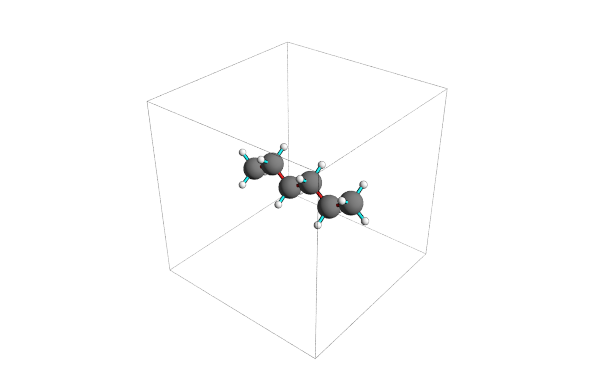

In [8]:
render(atomistic_frame)

HOOMD-blue interfaces with Python, numpy arrays etc. quite well. LAMMPS does not. Here is a lammps ``molecule`` input format example: 
```
LAMMPS init_LJ.data

81000 atoms
78300 bonds
... (angles, dihedrals etc.)
1 atom types
1 bond types
...
-15.0 15.0 xlo xhi
-15.0 15.0 ylo yhi
-15.0 15.0 zlo zhi

Atoms # molecular

1 0 1 -12.24552250 0.87371129 -9.40694904 0 0 0
2 0 1 -12.38426399 0.86507660 -9.85530090 0 0 0
3 0 1 -12.66414928 0.51184899 -9.93381596 0 0 0
...
80999 0 1 5.49844456 1.06321025 -14.68948841 0 0 1
81000 0 1 5.65934801 1.56205034 14.95873928 0 0 0

Velocities

1      0.18822558     -0.46999511     -1.24620414
2      1.17295206     -2.47768331     -0.78099817
...
80999     -2.11453247      0.17096603      2.44712496
81000     -2.89433742      0.77259320     -0.67590165

Masses

   1         1.0

Bonds

1 1 1 2
2 1 2 3
3 1 3 4
4 1 4 5
...
78300 1 80999 81000

Angles 

....
```

Lammps output ``.xyz`` format example (ethane molecule): 

```
8

C 0.0037516673155329567 -0.00025115260070535567 0.023748332684006536
H 0.022944471155959566 -0.028895556856709956 0.12719137280399623
H 0.07129048767437511 -0.05751711636195288 -0.039879061595043945
H -0.09831795229653163 -0.02978021532834491 -0.0007293177422955203
C 0.023748332684006602 0.15025115260070523 0.0037516673155329455
H -0.039879061595043834 0.20751711636195275 0.07129048767437511
H -0.00072931774229545 0.17978021532834487 -0.09831795229653162
H 0.1271913728039963 0.1788955568567098 0.022944471155959552
```